In [1]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)

import tensorflow as tf
tf.random.set_seed(2)

from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GRU

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [2]:
df = pd.read_csv('output.csv')
df.head()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
0,2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
1,2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2,2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
3,2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
4,2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [3]:
df.tail()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
102925,2015-12-30 00:05:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102926,2015-12-30 00:10:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102927,2015-12-30 00:15:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102928,2015-12-30 00:20:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102929,2015-12-30 00:25:00,18.35,33.0,0,0.0,430.0,0.0,0.01


In [4]:
#Find missing data!
pd.date_range('2015-01-06 15:00:00', '2015-12-30 00:25:00', freq='5Min').difference(pd.to_datetime(df["time"]))

DatetimeIndex(['2015-03-29 02:00:00', '2015-03-29 02:05:00',
               '2015-03-29 02:10:00', '2015-03-29 02:15:00',
               '2015-03-29 02:20:00', '2015-03-29 02:25:00',
               '2015-03-29 02:30:00', '2015-03-29 02:35:00',
               '2015-03-29 02:40:00', '2015-03-29 02:45:00',
               '2015-03-29 02:50:00', '2015-03-29 02:55:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
df.isna().sum()

time                       0
Toffice_reference          0
humidity                   0
detected_motions           0
occupancy                  0
office_CO2_concentratio    0
door                       0
label                      0
dtype: int64

In [6]:
df["time"]= pd.to_datetime(df["time"])
df.set_index(["time"], inplace=True)
df.head()

,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
time,,,,,,,
2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [7]:
df.drop(['Toffice_reference', 'humidity', 'detected_motions', 'occupancy', 'office_CO2_concentratio','door'], axis=1, inplace=True)

In [8]:
df.head()

,label
time,
2015-01-06 15:00:00,1.128000
2015-01-06 15:05:00,0.622000
2015-01-06 15:10:00,0.634000
2015-01-06 15:15:00,0.285733
2015-01-06 15:20:00,0.094000


In [9]:
df[df['label']<0] = 0

In [10]:
df[df['label']<0]

,label
time,


In [11]:
data_per_5min = df
data_per_Hour = df.resample('H').sum()
data_per_5min.shape, data_per_Hour.shape

((102930, 1), (8578, 1))

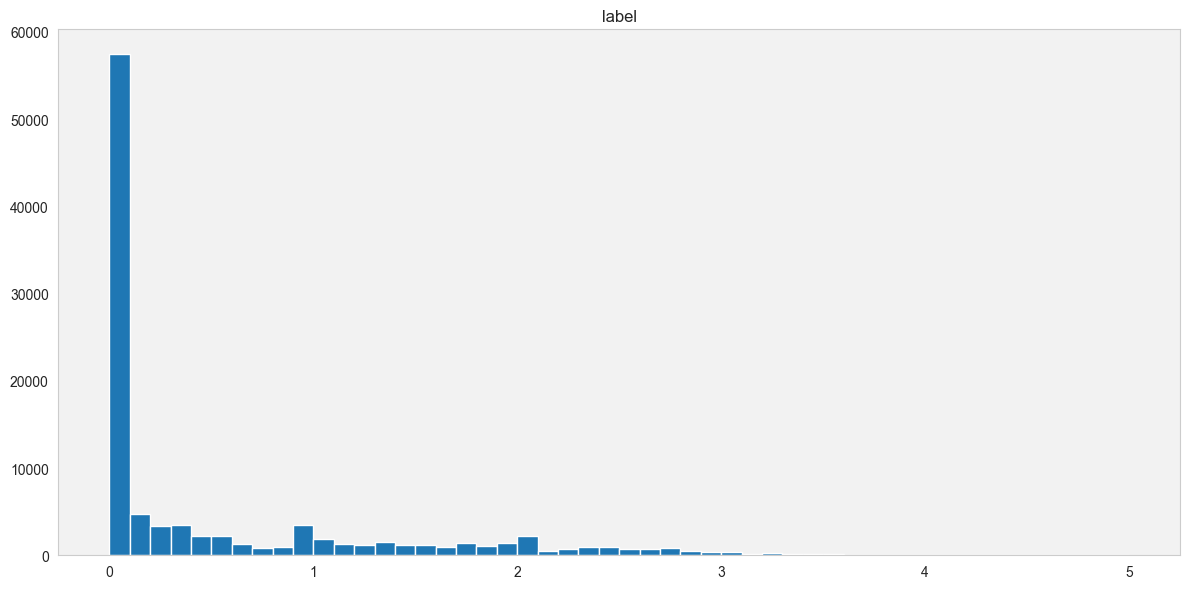

In [12]:
df.hist(bins=50)
plt.tight_layout()

<AxesSubplot:ylabel='label'>

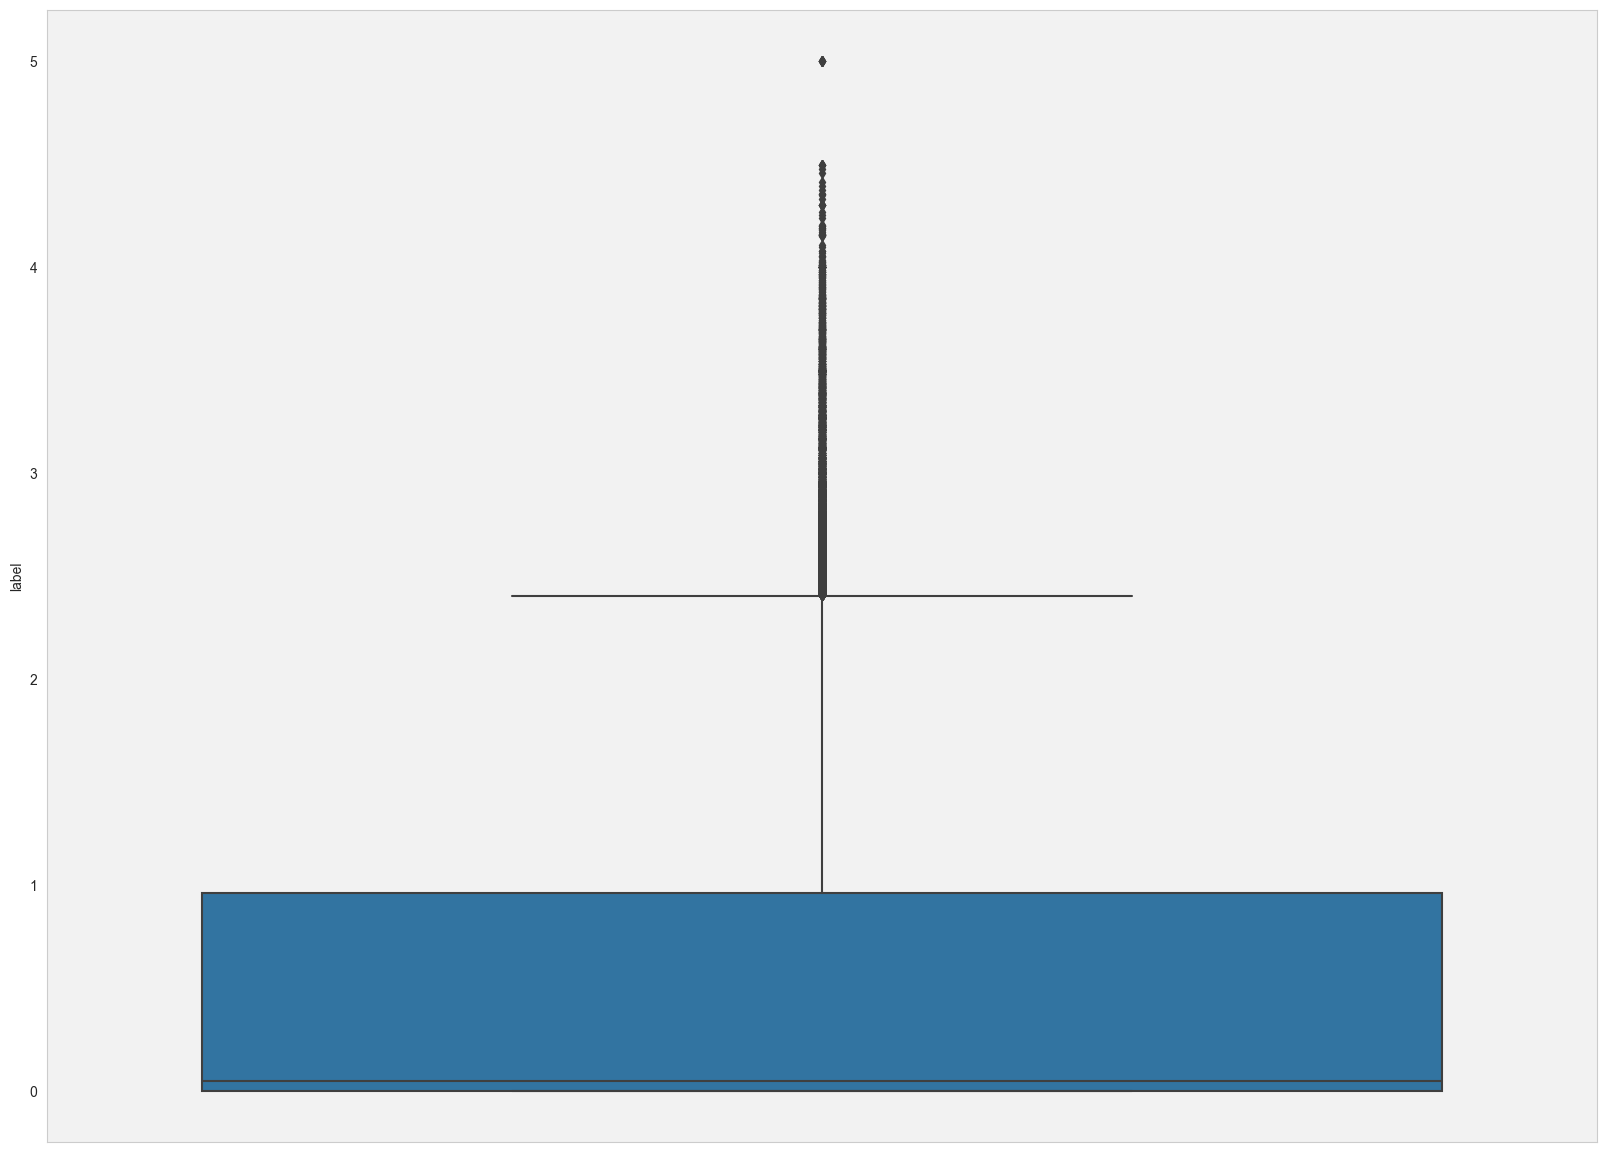

In [13]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(data=df, y='label')



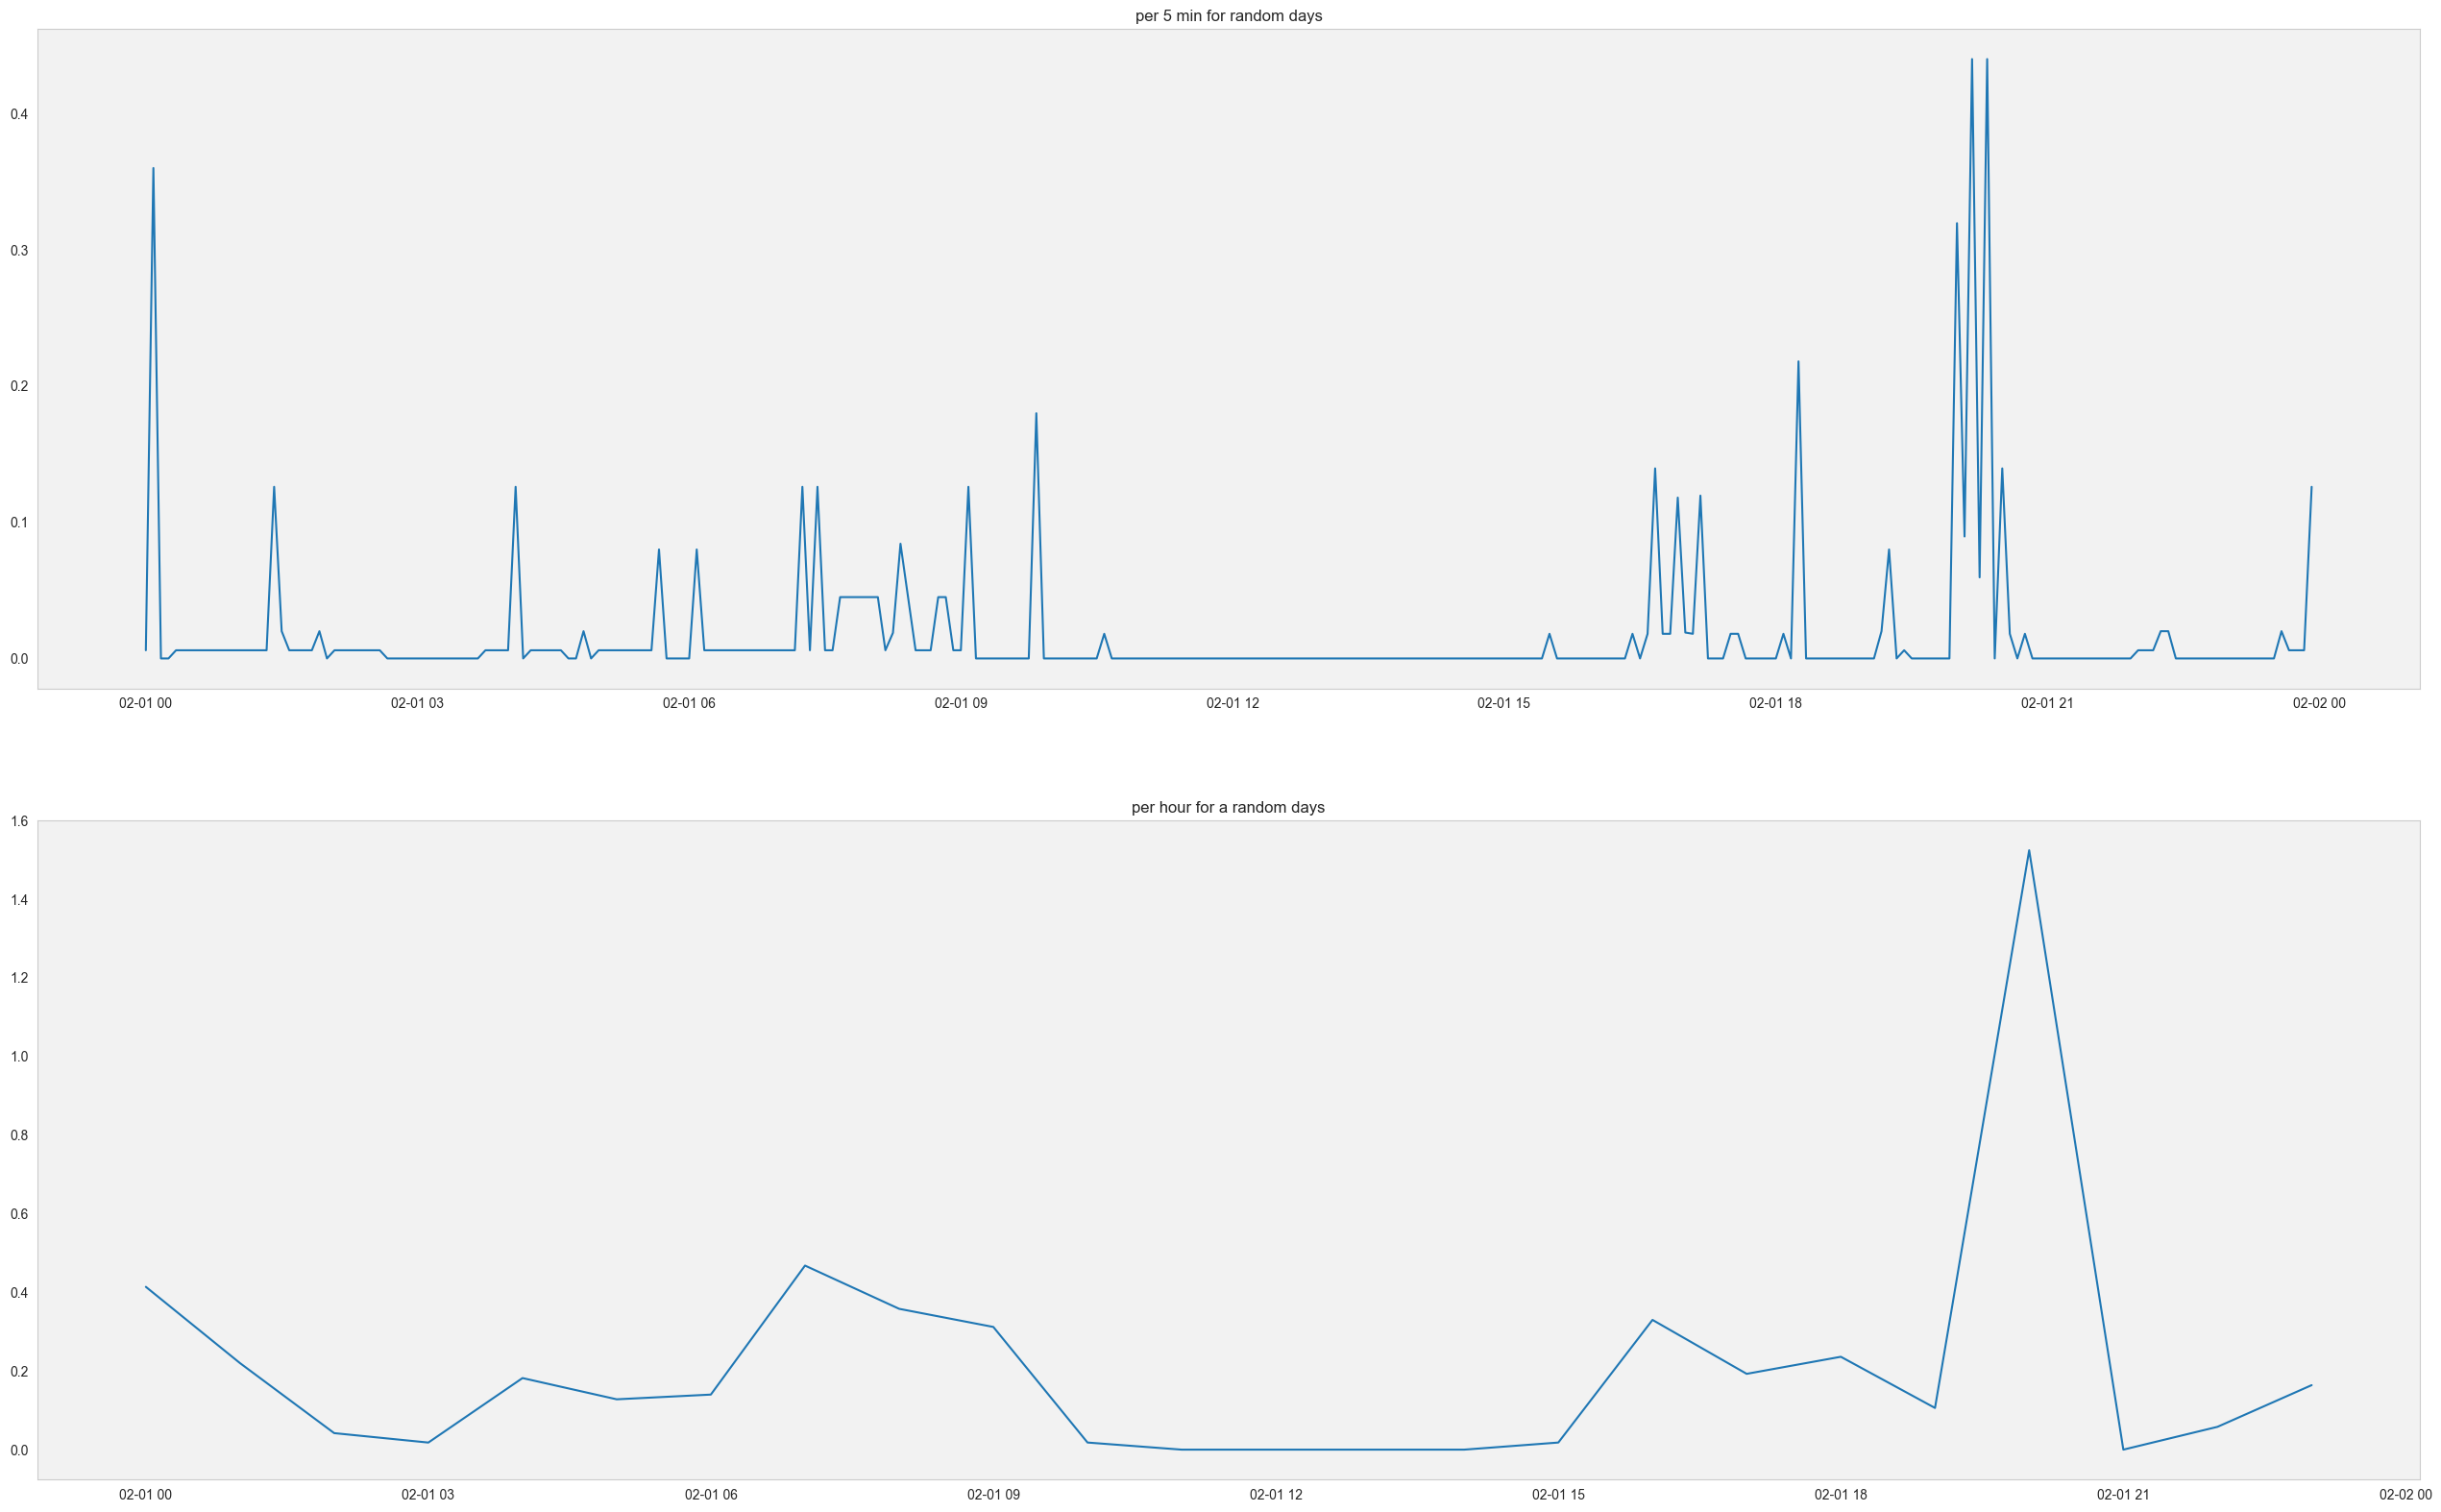

In [14]:
fig, ax = plt.subplots(figsize=(32,20))

plt.subplot(2, 1, 1)
plt.plot(data_per_5min.loc['2015-02-01']['label'])
#plt.plot(data_per_5min['occupancy'])
#plt.plot(data_per_H.loc['2019-05-01':'2019-05-07',:])
plt.title('per 5 min for random days')


plt.subplot(2, 1, 2)
plt.plot(data_per_Hour['2015-02-01']['label'])
#plt.plot(data_per_D.loc['2019-05',:])
plt.title('per hour for a random days')



plt.show()
fig.tight_layout()

In [15]:
# fig = plt.figure(figsize=(20, 15))
# ax1 = fig.add_subplot(211)
# sns.boxplot(data=data, x='month', y='label', ax=ax1)
# ax2 = fig.add_subplot(212)
# sns.boxplot(data=data, x='weekday', y='label', ax=ax2)
# # ax3 = fig.add_subplot(313)
# # sns.boxplot(data=df, x='holiday', y='label', ax=ax3)
# plt.show()

In [16]:
data = data_per_Hour[:]

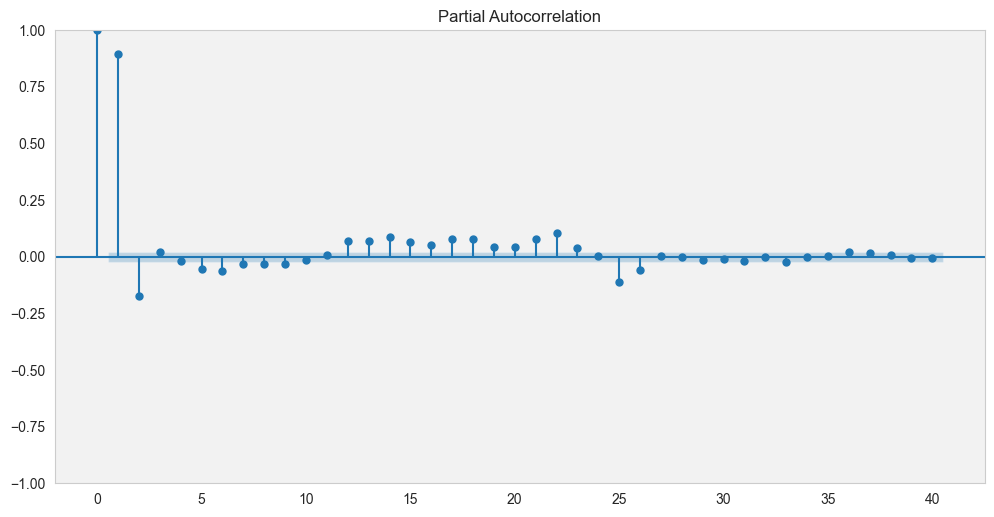

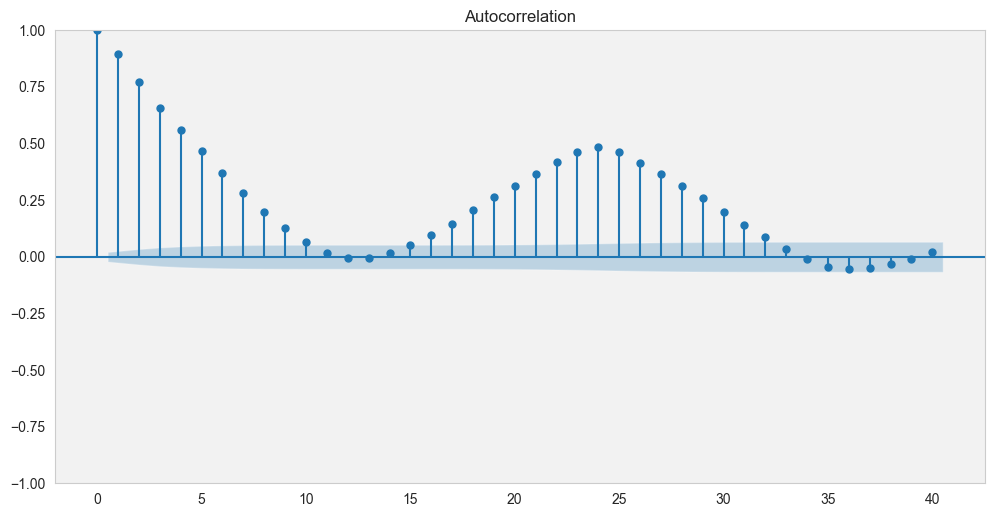

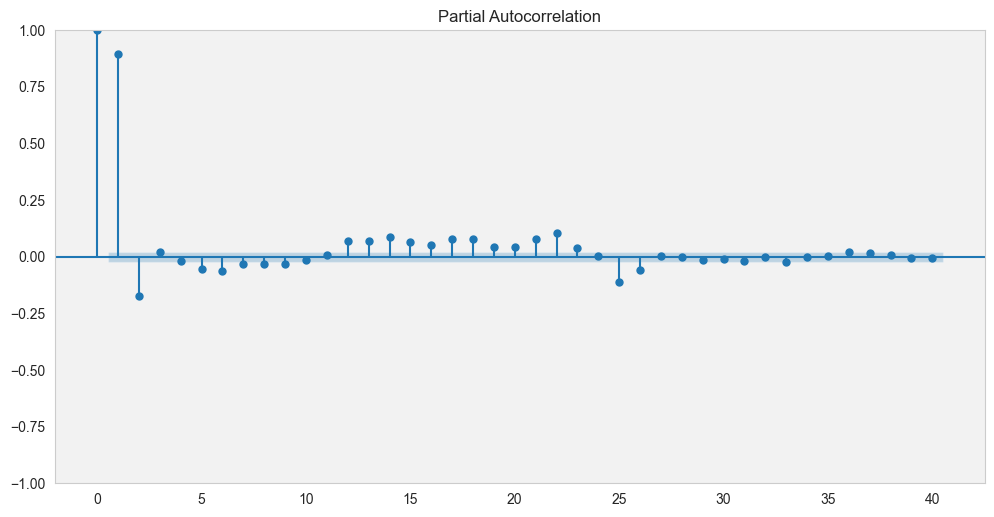

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['label'])
plot_pacf(data['label'])

In [18]:
data.head()

,label
time,
2015-01-06 15:00:00,3.269733
2015-01-06 16:00:00,21.968880
2015-01-06 17:00:00,22.115866
2015-01-06 18:00:00,31.237733
2015-01-06 19:00:00,32.699347


# add simple cal features

In [19]:
import holidays

def add_time_features(df):
    cet_index = df.index
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    #df["year"] = cet_index.year
    return df

def add_holiday_features(df):
    de_holidays = holidays.France()
    cet_dates = pd.Series(df.index, index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df


def add_all_features(df, target_col="conso_global"):
    df = df.copy()
    df = add_time_features(df)
    #df = add_holiday_features(df)
    return df

In [20]:
data = add_all_features(data)

In [21]:
data.head()

,label,month,weekday,hour
time,,,,
2015-01-06 15:00:00,3.269733,1,1,15
2015-01-06 16:00:00,21.968880,1,1,16
2015-01-06 17:00:00,22.115866,1,1,17
2015-01-06 18:00:00,31.237733,1,1,18
2015-01-06 19:00:00,32.699347,1,1,19


## Importing the calendar

In [22]:
from icalendar import Calendar, Event
from datetime import datetime

In [23]:
evenement = []
debut = []
fin =[]


g = open('stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(0)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

# plt.figure(figsize=(20,9))
# data['label'].plot()
# data['calendrier'].plot()
# plt.show()

In [24]:
data.head()

,label,month,weekday,hour
time,,,,
2015-01-06 15:00:00,3.269733,1,1,15
2015-01-06 16:00:00,21.968880,1,1,16
2015-01-06 17:00:00,22.115866,1,1,17
2015-01-06 18:00:00,31.237733,1,1,18
2015-01-06 19:00:00,32.699347,1,1,19


In [25]:
data.drop(['nom'], axis =1, inplace=True)

In [26]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
sns.boxplot(data=data, x='calendrier', y='label', ax=ax1)
plt.show()

# window 12h: 

In [27]:
# LEADS
leads = np.arange(11)
lead_cols = [f"label_lead_{lead+1}" for lead in leads ]
for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = data["label"].shift(-(lead+1))

hour_leads = [f"hour_lead_{lead+1}" for lead in leads ]
weekday_leads = [f"weekday_lead_{lead+1}" for lead in leads ]
month_leads = [f"month_lead_{lead+1}" for lead in leads ]
# cal_leads = [f"cal_lead_{lead+1}" for lead in leads ]


for lead, lead_H in zip(leads, hour_leads):
    data[lead_H] = data["hour"].shift(-(lead+1))
    
for lead, lead_W in zip(leads, weekday_leads):
    data[lead_W] = data["weekday"].shift(-(lead+1))
    
for lead, lead_M in zip(leads, month_leads):
    data[lead_M] = data["month"].shift(-(lead+1))
    
# for lead, lead_C in zip(leads, cal_leads):
#     data[lead_C] = data["calendrier"].shift(-(lead+1))    
    


In [28]:
#LAGS
lags = np.arange(1,25)
lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["label"].shift(lag)
    
hour_lags = [f"hour_lag_{lag}" for lag in lags ]
weekday_lags = [f"weekday_lag_{lag}" for lag in lags ]
month_lags = [f"month_lag_{lag}" for lag in lags ]
# cal_lags = [f"cal_lag_{lag}" for lag in lags ]


for lag, lag_H in zip(lags, hour_lags):
    data[lag_H] = data["hour"].shift(lag)
    
for lag, lag_W in zip(lags, weekday_lags):
    data[lag_W] = data["weekday"].shift(lag)
    
for lag, lag_M in zip(lags, month_lags):
    data[lag_M] = data["month"].shift(lag)

# for lag, lag_C in zip(lags, cal_lags):
#     data[lag_C] = data["calendrier"].shift(lag)
    


        

In [29]:
#Rolling 

wins = [12, 24, 36, 48, 60]
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).mean())
#         data[f"rmax_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).max())
#         data[f"rmin_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).min())
        data[f"rstd_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).std())

In [30]:
data.rename(columns={"label": "label_lead_0"}, inplace= True)

In [31]:
data.tail()

,label_lead_0,month,weekday,hour,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,label_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 20:00:00,0.00,12,1,20,0.14,0.11,0.12,0.06,NaN,NaN,...,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862,2.567506,3.207641,2.590233,3.194756
2015-12-29 21:00:00,0.14,12,1,21,0.11,0.12,0.06,NaN,NaN,NaN,...,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862,2.567506,3.207641
2015-12-29 22:00:00,0.11,12,1,22,0.12,0.06,NaN,NaN,NaN,NaN,...,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862
2015-12-29 23:00:00,0.12,12,1,23,0.06,NaN,NaN,NaN,NaN,NaN,...,2.089274,2.808858,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680
2015-12-30 00:00:00,0.06,12,2,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.990514,2.699857,2.089274,2.808858,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452


In [32]:
data.dropna(inplace=True)

In [33]:
data.tail()

,label_lead_0,month,weekday,hour,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,label_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 09:00:00,0.000000,12,1,9,0.699200,2.270400,1.292309,1.098200,1.191491,1.323055,...,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877,2.832964,3.039176,2.825156,3.042098
2015-12-29 10:00:00,0.699200,12,1,10,2.270400,1.292309,1.098200,1.191491,1.323055,1.476000,...,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877,2.832964,3.039176
2015-12-29 11:00:00,2.270400,12,1,11,1.292309,1.098200,1.191491,1.323055,1.476000,1.500200,...,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877
2015-12-29 12:00:00,1.292309,12,1,12,1.098200,1.191491,1.323055,1.476000,1.500200,1.502444,...,2.688332,3.134894,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711
2015-12-29 13:00:00,1.098200,12,1,13,1.191491,1.323055,1.476000,1.500200,1.502444,0.119043,...,2.663732,3.150322,2.688332,3.134894,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255


In [34]:
#Scaling
scaler = MinMaxScaler()
data['label_lead_0'] = scaler.fit_transform(pd.DataFrame(data['label_lead_0']))

leads = np.arange(11)
lead_cols = [f"label_lead_{lead+1}" for lead in leads ]
for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = scaler.transform(pd.DataFrame(data[lead_col]))
   

lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag_col in lag_cols:
    data[lag_col] = scaler.transform(pd.DataFrame(data[lag_col]))

    
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmean_{lag}_{win}"]))
#         data[f"rmax_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmax_{lag}_{win}"]))
#         data[f"rmin_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmin_{lag}_{win}"]))
        data[f"rstd_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rstd_{lag}_{win}"]))

In [35]:
# make 12 step window no overlap
data = data.iloc[[i for i in range(0,len(data),12)]]
data

,label_lead_0,month,weekday,hour,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,label_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-01-10 02:00:00,0.000000,1,5,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.093176,0.162702,0.103379,0.175475,0.110411,0.180131,0.117591,0.184195,0.118614,0.183716
2015-01-10 14:00:00,0.589809,1,5,14,0.440792,0.238338,0.097323,0.174303,0.141773,0.022883,...,0.125990,0.205592,0.119746,0.202365,0.109178,0.186020,0.098273,0.166618,0.090035,0.154623
2015-01-11 02:00:00,0.000000,1,6,2,0.000000,0.001804,0.000588,0.000000,0.000000,0.000588,...,0.153598,0.222311,0.153698,0.222242,0.153749,0.222207,0.154127,0.221960,0.154176,0.221925
2015-01-11 14:00:00,0.000000,1,6,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.192773,0.233151,0.189930,0.234416,0.188867,0.234988,0.184945,0.236108,0.177622,0.234849
2015-01-12 02:00:00,0.004974,1,0,2,0.015529,0.021843,0.038199,0.083686,0.075961,0.111760,...,0.154499,0.227866,0.158025,0.227070,0.161827,0.226298,0.162574,0.225834,0.163139,0.225463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27 02:00:00,0.021474,12,6,2,0.023363,0.021533,0.023363,0.022906,0.025768,0.040290,...,0.017969,0.018290,0.017513,0.018353,0.017031,0.018428,0.016548,0.018489,0.016066,0.018538
2015-12-27 14:00:00,0.000000,12,6,14,0.000000,0.000000,0.000000,0.000000,0.000355,0.000000,...,0.033392,0.049409,0.031140,0.046698,0.028910,0.043698,0.026838,0.040355,0.024753,0.036588
2015-12-28 02:00:00,0.030106,12,0,2,0.037408,0.061694,0.064439,0.040843,0.007161,0.000000,...,0.053150,0.060432,0.052769,0.060698,0.052379,0.060964,0.052020,0.061212,0.051631,0.061471


In [36]:
707 *0.75

530.25

In [37]:
train_data = data.iloc[0:530]
test_data = data.iloc[530:]

train_data.shape, test_data.shape

((530, 384), (177, 384))

In [38]:
lead_cols

['label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11']

In [39]:
lead_cols.insert(0, "label_lead_0") 
lead_cols

['label_lead_0',
 'label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11']

In [40]:
x_train_data = train_data.drop(lead_cols, axis=1)
y_train_data = train_data.loc[:, lead_cols]
x_test_data = test_data.drop(lead_cols, axis=1)
y_test_data = test_data.loc[:, lead_cols]

In [41]:
y_train_data

,label_lead_0,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,label_lead_6,label_lead_7,label_lead_8,label_lead_9,label_lead_10,label_lead_11
time,,,,,,,,,,,,
2015-01-10 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023604,0.458870,0.519696
2015-01-10 14:00:00,0.589809,0.440792,0.238338,0.097323,0.174303,0.141773,0.022883,0.013497,0.003707,0.007590,0.001686,0.004118
2015-01-11 02:00:00,0.000000,0.000000,0.001804,0.000588,0.000000,0.000000,0.000588,0.006535,0.000000,0.000000,0.000000,0.000000
2015-01-11 14:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000355,0.000353,0.001412,0.001412
2015-01-12 02:00:00,0.004974,0.015529,0.021843,0.038199,0.083686,0.075961,0.111760,0.495158,0.483788,0.471921,0.517523,0.503468
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-29 14:00:00,0.372914,0.421254,0.458821,0.499441,0.323518,0.262002,0.242507,0.083739,0.011940,0.005584,0.007230,0.007230
2015-09-30 02:00:00,0.007230,0.000392,0.000000,0.032995,0.007059,0.000000,0.059814,0.603113,0.573188,0.428225,0.372558,0.261057
2015-09-30 14:00:00,0.267007,0.356133,0.330306,0.341235,0.338754,0.271536,0.053768,0.042394,0.000178,0.000000,0.000000,0.000000


In [42]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

In [43]:
threshold = -2
features = []
for col in y_train_data.columns:
    correlation = pd.DataFrame(train_data.drop(lead_cols, axis=1).corrwith(train_data[col]), columns=['corr'])
    thresh_corr = correlation[correlation['corr']> threshold]
    features.append(list(thresh_corr.index))

In [44]:
param = {
    "objective":'regression',
    "is_unbalance":True,
    'learning_rate': 0.03718140629054298,
    'max_depth': 2,
    'num_leaves': 210,
    'min_child_samples': 28
            }

In [45]:
from tqdm import tqdm

result = pd.DataFrame()
models = dict()
for counter, col in enumerate(tqdm(y_train_data.columns)):
    
    result[f'pred_{counter}'] = np.zeros(y_test_data.shape[0])
    
    used_features = features[counter]
    
    x_train_local = x_train_data.loc[:, used_features]
    y_train_local = y_train_data.loc[:, col]
    x_test_local = x_test_data.loc[:, used_features]
    y_test_local = y_test_data.loc[:, col]
    
    
    model = lgbm.LGBMRegressor(
            learning_rate= param["learning_rate"],
            max_depth= param["max_depth"],
            num_leaves= param["num_leaves"],
            objective= param["objective"],
            is_unbalance=param["is_unbalance"],
            min_child_samples=param['min_child_samples']
    )

    n_splits = 6
    cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    val_scores = [0] * n_splits




    #feature_importances = pd.DataFrame(index=x_train_local.columns)

    for i, (fit_idx, val_idx) in enumerate(cv.split(x_train_local, y_train_local)):

        X_fit = x_train_local.iloc[fit_idx]
        y_fit = y_train_local.iloc[fit_idx]
        X_val = x_train_local.iloc[val_idx]
        y_val = y_train_local.iloc[val_idx]

        model.fit(
            X_fit,
            y_fit,
            eval_set=[(X_fit, y_fit), (X_val, y_val)],
            eval_names=('fit', 'val'),
            eval_metric='l2',
            early_stopping_rounds=200,
            feature_name=X_fit.columns.tolist(),
            verbose=False
        )

        val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
        result[f'pred_{counter}'] += model.predict(x_test_local, num_iteration=model.best_iteration_)
        #feature_importances[i] = model.feature_importances_

        print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))

    result[f'pred_{counter}'] /= n_splits
    result[f'pred_{counter}'] = np.expm1(result[f'pred_{counter}'])

    val_mean = np.mean(val_scores)
    val_std = np.std(val_scores)

    print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))
    models[col] = model

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Fold 1 RMSLE: 0.06757
Fold 2 RMSLE: 0.08338
Fold 3 RMSLE: 0.10172
Fold 4 RMSLE: 0.07831
Fold 5 RMSLE: 0.08248
Fold 6 RMSLE: 0.08667


  8%|██████▉                                                                            | 1/12 [00:00<00:06,  1.71it/s]

Local RMSLE: 0.08335 (±0.01020)
Fold 1 RMSLE: 0.08332
Fold 2 RMSLE: 0.08907
Fold 3 RMSLE: 0.09424
Fold 4 RMSLE: 0.10143


 17%|█████████████▊                                                                     | 2/12 [00:01<00:05,  1.69it/s]

Fold 5 RMSLE: 0.09629
Fold 6 RMSLE: 0.08217
Local RMSLE: 0.09109 (±0.00693)
Fold 1 RMSLE: 0.08787
Fold 2 RMSLE: 0.08527
Fold 3 RMSLE: 0.10521
Fold 4 RMSLE: 0.12127
Fold 5 RMSLE: 0.10301
Fold 6 RMSLE: 0.09098


 25%|████████████████████▊                                                              | 3/12 [00:01<00:05,  1.71it/s]

Local RMSLE: 0.09893 (±0.01243)
Fold 1 RMSLE: 0.09986
Fold 2 RMSLE: 0.08640
Fold 3 RMSLE: 0.13650
Fold 4 RMSLE: 0.11938


 33%|███████████████████████████▋                                                       | 4/12 [00:02<00:04,  1.72it/s]

Fold 5 RMSLE: 0.10562
Fold 6 RMSLE: 0.11362
Local RMSLE: 0.11023 (±0.01572)
Fold 1 RMSLE: 0.09838
Fold 2 RMSLE: 0.09638
Fold 3 RMSLE: 0.13928
Fold 4 RMSLE: 0.10517


 42%|██████████████████████████████████▌                                                | 5/12 [00:02<00:04,  1.73it/s]

Fold 5 RMSLE: 0.10299
Fold 6 RMSLE: 0.11539
Local RMSLE: 0.10960 (±0.01460)
Fold 1 RMSLE: 0.10707
Fold 2 RMSLE: 0.10556
Fold 3 RMSLE: 0.13016
Fold 4 RMSLE: 0.09527


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:03<00:03,  1.71it/s]

Fold 5 RMSLE: 0.10335
Fold 6 RMSLE: 0.12999
Local RMSLE: 0.11190 (±0.01338)
Fold 1 RMSLE: 0.09879
Fold 2 RMSLE: 0.11389
Fold 3 RMSLE: 0.12936
Fold 4 RMSLE: 0.09906
Fold 5 RMSLE: 0.10778


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:04<00:02,  1.67it/s]

Fold 6 RMSLE: 0.12699
Local RMSLE: 0.11265 (±0.01216)
Fold 1 RMSLE: 0.11305
Fold 2 RMSLE: 0.13181
Fold 3 RMSLE: 0.14677
Fold 4 RMSLE: 0.11652
Fold 5 RMSLE: 0.13836


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:04<00:02,  1.69it/s]

Fold 6 RMSLE: 0.14029
Local RMSLE: 0.13113 (±0.01239)
Fold 1 RMSLE: 0.12851
Fold 2 RMSLE: 0.11844
Fold 3 RMSLE: 0.16079
Fold 4 RMSLE: 0.15121
Fold 5 RMSLE: 0.15964


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:05<00:01,  1.70it/s]

Fold 6 RMSLE: 0.15053
Local RMSLE: 0.14485 (±0.01586)
Fold 1 RMSLE: 0.12644
Fold 2 RMSLE: 0.12221
Fold 3 RMSLE: 0.16189
Fold 4 RMSLE: 0.13901
Fold 5 RMSLE: 0.14489


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:05<00:01,  1.71it/s]

Fold 6 RMSLE: 0.13755
Local RMSLE: 0.13867 (±0.01291)
Fold 1 RMSLE: 0.13965
Fold 2 RMSLE: 0.10983
Fold 3 RMSLE: 0.15725
Fold 4 RMSLE: 0.12497
Fold 5 RMSLE: 0.13154


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:06<00:00,  1.72it/s]

Fold 6 RMSLE: 0.14495
Local RMSLE: 0.13470 (±0.01506)
Fold 1 RMSLE: 0.13203
Fold 2 RMSLE: 0.11599
Fold 3 RMSLE: 0.15904
Fold 4 RMSLE: 0.10785
Fold 5 RMSLE: 0.14799


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.71it/s]

Fold 6 RMSLE: 0.13917
Local RMSLE: 0.13368 (±0.01761)


In [46]:
result

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11
0,0.010500,0.012606,0.025246,0.018321,0.020267,0.029865,0.064542,0.129370,0.207197,0.215913,0.197172,0.143000
1,0.741713,0.646490,0.627765,0.519732,0.456930,0.435574,0.268357,0.206385,0.134510,0.063627,0.030276,0.024749
2,0.317161,0.158869,0.149867,0.181958,0.172607,0.153974,0.114014,0.122950,0.189070,0.216255,0.272467,0.249253
3,0.063780,0.097178,0.093257,0.161614,0.163311,0.169391,0.168490,0.140425,0.132580,0.122150,0.073153,0.065027
4,-0.000120,0.013859,0.010375,0.021166,0.009817,0.008588,0.000510,0.018546,0.061674,0.069422,0.052653,0.038707
...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.213094,0.183329,0.180795,0.142214,0.122669,0.102689,0.076032,0.062998,0.062473,0.048349,0.059147,0.040207
173,0.014308,0.017480,0.027744,0.015116,0.020946,0.039921,0.059705,0.024443,0.061814,0.060730,0.058588,0.070832
174,0.067093,0.067364,0.058720,0.060928,0.051275,0.035918,0.037417,0.153524,0.218432,0.248838,0.203193,0.232782
175,0.012375,0.014236,0.015274,0.016538,0.017187,0.017163,0.025318,0.130466,0.130745,0.117911,0.098572,0.089283


In [47]:
final_test = y_test_data.values.flatten()
final_resut = result.values.flatten()

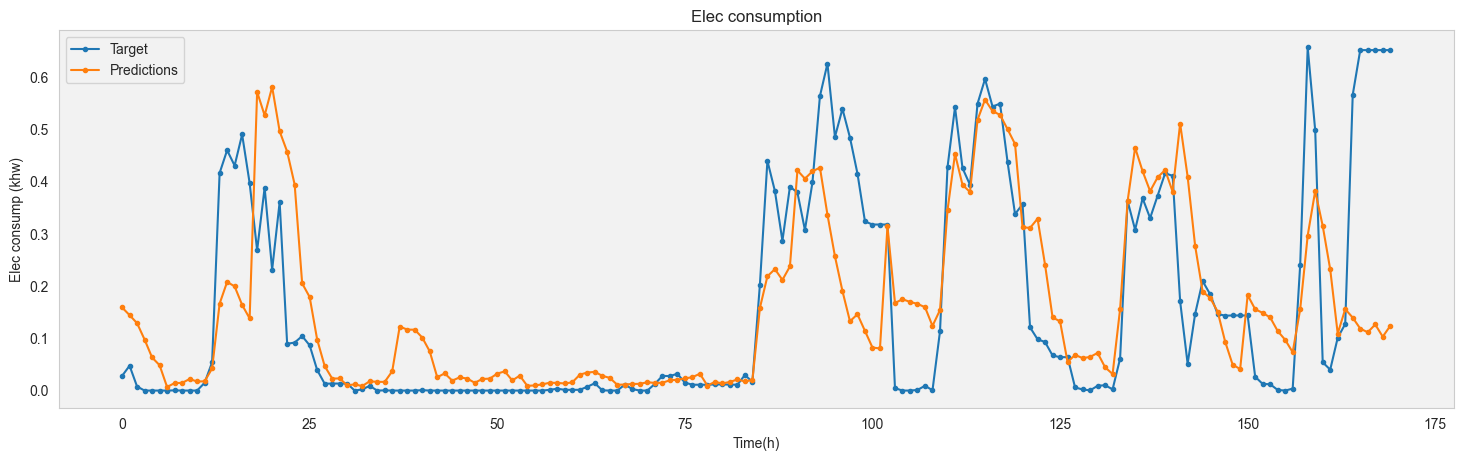

In [48]:
plt.figure(figsize=(18,5))

plt.plot(final_test[330:500], marker='.',label='Target')
plt.plot(final_resut[330:500], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [49]:
print( "The RMSE for Stacked LSTM model is: %f" %np.sqrt(mean_squared_error(final_test,final_resut)))
print( "The accuracy of Stacked LSTM model is: %f" %r2_score(final_test,final_resut))

The RMSE for Stacked LSTM model is: 0.144799
The accuracy of Stacked LSTM model is: 0.502439
